# Project 3 

#### Suzanne McGann, Data Scientist

### Executive Summary 

This project focuses on posts captured from 2 subreddits: hiking and climbing. Through testing two vectorzing techniques (Count Vectorizer and TF-IDF) and three statistical models (Random Forest Classifier, Extra Trees Classifier, and Naive Bayes (Multinomial)), this analysis predicts where a subreddit post was published (hiking or climbing). Analysis and modeling for this task proved interesting for 2 key reasons: 
    1. While technically distinct, the topics of hiking and climbing share themes, standard vernacular, and subreddit participants (participants = authors and commenters). 
    2. Many of these posts are picture intensive, making the process of NLP more challenging. (Important note: a second installment to this project will soon be available on https://stmcgann.github.io/ where the same posts are analyzed using Neural Networks. Instead of focusing on the text attributes of each post, the analysis will be based solely on analysis of the pictures that accompany each post). 

Using a publically available pushshift API, 3974 climbing posts and 2312 hiking posts were captured and saved into separate data frames. Each data frame captured the same 9 features ('title', 'selftext', 'subreddit', 'created_utc', 'author', 'num_comments', 'score', 'is_self') so they could easily be concatenated into a single data frame. The final data frame ('df') contains 6286 rows and 10 features. The additional feature, 'text_concat', is the combination of the 'title' and 'selftext' feature; 'text_concat' is the feature that was vectorized in this notebook. 

Two tree methods (Random Forest Classifier and Extra Tree Classifier) and one regression metric (Multinomial Naive Bayes) were used on the subreddit data. The Multinomial Naive Bayes model with the count vectorizer resulted in the best performing model, classifying the correct subreddit 95.3% of the time on my testing data set. Further, out of the 6286 posts, the Naive Bayes model only falsely predicted hiking 27 times and falsely predicted climbing 32 times on the test data. On the test data, the Naive Bayes model correctly predicted climbing 768 times and correctly predicted hiking 431 times. 
       1. False Positives: 27
       2. False Negatives: 32
       3. True Negatives: 768
       4. True Positives: 431
In analyzing the best performing Random Forest model, the top 10 most predictive, non-lemmatized words were: 'hiking', 'climbing', 'hike', 'trail', 'hikes', 'trails', 'climb', 'climber', 'boots', 'climbers'. 

### Pushshift API = "Climbing" DataFrame & "Hiking" DataFrame

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import time
import requests 
import json 
np.random.seed(42)

In [ ]:
# the Query_pushshift function takes in 5 arguments. 
    # 4 of the arguments are hardcoded 
        # kind = the "endpoint" of the URL before the query string. It is set to 'submission'
        # skip = how many days each loop is going to skip over after completing a run 
        # times = the number of times the loop is going to run 
        # subfield = the specific keys (whic will be features in the df) that the function is going to capture 
    # 1 argument, 'subreddit', is not hardcoded so the function could easily be reused for each of my subreddits 
def query_pushshift(subreddit, kind='submission', skip=2, times=150, 
                    subfield = ['title', 'selftext', 'subreddit', 'created_utc', 'author', 'num_comments', 'score', 'is_self']):

    stem = "https://api.pushshift.io/reddit/search/{}/?subreddit={}&size=500".format(kind, subreddit)
    mylist = []
    
    for x in range(1, times):
        
        URL = "{}&after={}d".format(stem, skip * x)
        print(URL)
        response = requests.get(URL)
        assert response.status_code == 200
        mine = response.json()['data']
        df = pd.DataFrame.from_dict(mine)
        mylist.append(df)
        time.sleep(0.25)
        
    full = pd.concat(mylist)
    
    if kind == "submission":
        
        full = full[subfield]
        
        full = full.drop_duplicates()
        
        full = full.loc[full['is_self'] == True]
        
    def get_date(created):
        return dt.date.fromtimestamp(created)
    
    _timestamp = full["created_utc"].apply(get_date)
    
    full['timestamp'] = _timestamp

    print(full.shape)
    
    return full 

In [ ]:
# Calling the function for each data frame 

In [ ]:
climb_df = query_pushshift("climbing")
hike_df = query_pushshift("hiking")

In [ ]:
# Exporting to CSV 
    # This step was necessary because I was working out of several notebooks 
climb_df.to_csv("../project-3/CLIMBDATA.csv")
hike_df.to_csv("../project-3/HIKEDATA.csv")

### Setting up data for EDA

In [4]:
climb = pd.read_csv("../project-3/CLIMBDATA.csv").drop('Unnamed: 0', axis=1)
hike = pd.read_csv("../project-3/HIKEDATA.csv").drop('Unnamed: 0', axis=1)

print(climb.shape, hike.shape)

frames = [hike, climb]

df = pd.concat(frames)

print(df.shape)
df.head(3)

(3974, 9) (2312, 9)
(6286, 9)


,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,"New hikers and the Franconia Ridge Loop, New H...",My bf and I have recently started getting into...,hiking,1536176424,wateryoplants,6,1,True,2018-09-05
1,Mole skin vs duct tape,I usually get bad blisters when hiking even wi...,hiking,1536183866,Tomg245,8,1,True,2018-09-05
2,Hey Runners! We're a group of students learnin...,[https://goo.gl/forms/EmIsYrhPzJe5EREP2](https...,hiking,1536183992,41Kix,1,1,True,2018-09-05


### EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6286 entries, 0 to 3973
Data columns (total 9 columns):
title           6286 non-null object
selftext        5988 non-null object
subreddit       6286 non-null int64
created_utc     6286 non-null int64
author          6286 non-null object
num_comments    6286 non-null int64
score           6286 non-null int64
is_self         6286 non-null bool
timestamp       6286 non-null object
dtypes: bool(1), int64(4), object(4)
memory usage: 448.1+ KB


In [3]:
# Changing the values of the target feature to be binary 
df['subreddit'] = df['subreddit'].map({'hiking':1, 'climbing':0})

In [4]:
df['subreddit'].value_counts()

0    3974
1    2312
Name: subreddit, dtype: int64

In [5]:
# Combining title + selftext features. 
# Because there are NULL values in 'selftext', I am going to populate the concatenated feature with noise 
# From there, I will search and replace on the noise 

df['selftext'].fillna(" BANANAGRAMBANANAGRAMBANANAGRAM", inplace = True) 
print("Number of Null rows:", df['selftext'].isnull().sum()) 
df['text_concat'] = df['title']+df['selftext']
print(df.shape) # this now has 10 columns 
df.info()  # There are no longer any null values in selftext 

Number of Null rows: 0
(6286, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6286 entries, 0 to 3973
Data columns (total 10 columns):
title           6286 non-null object
selftext        6286 non-null object
subreddit       6286 non-null int64
created_utc     6286 non-null int64
author          6286 non-null object
num_comments    6286 non-null int64
score           6286 non-null int64
is_self         6286 non-null bool
timestamp       6286 non-null object
text_concat     6286 non-null object
dtypes: bool(1), int64(4), object(5)
memory usage: 497.2+ KB


In [6]:
# Getting rid of the noise 
df['text_concat'] = df['text_concat'].replace("BANANAGRAMBANANAGRAMBANANAGRAM", "")

#### Baseline Accuracy 

In [7]:
# Hiking = 1 
# Climbing = 0

df['subreddit'].value_counts(normalize =True)

# I am trying to predict 1 (hiking). My baseline accuracy is 36.7% 

0    0.632199
1    0.367801
Name: subreddit, dtype: float64

#### Importing Libraries 

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

### Train Test Split 

In [9]:
# Setting up my data for count vectorizer 
X = df['text_concat']
y = df['subreddit']

# Train test split 

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state = 42, 
                                                   test_size = 0.20, 
                                                   stratify = y )

X_train.shape, X_test.shape

((5028,), (1258,))

### Count Vectorizer & Random Forest

In [10]:
cv2 = CountVectorizer()
rf = RandomForestClassifier()

pipe_rf = Pipeline([ 
    ("cv2", cv2), 
    ("rf", rf)
])

params = { 
    "cv2__stop_words": [None, "english"], 
    "cv2__ngram_range": [(1,1), (1,2)], 
    "rf__criterion": ["gini", "entropy"], 
    "rf__n_estimators": [20, 27, 35]
}

gs_rf = GridSearchCV(pipe_rf,
                     param_grid = params)
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('cv2', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'cv2__stop_words': [None, 'english'], 'cv2__ngram_range': [(1, 1), (1, 2)], 'rf__criterion': ['gini', 'entropy'], 'rf__n_estimators': [20, 27, 35]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [14]:
print(gs_rf.best_params_)
print("3-fold Cross Validation Score on train data for Random Forest:", gs_rf.best_score_) 
print("Score on test data for Random Forest:", gs_rf.score(X_test, y_test)) 

{'cv2__ngram_range': (1, 1), 'cv2__stop_words': 'english', 'rf__criterion': 'gini', 'rf__n_estimators': 35}
3-fold Cross Validation Score on train data for Random Forest: 0.9427207637231504
Score on test data for Random Forest: 0.9451510333863276


### TF-IDF Vectorizer & Random Forest

In [27]:
tfidf = TfidfVectorizer()
rf2 = RandomForestClassifier()

pipe_tfidf_rf = Pipeline([ 
    ("tfidf", tfidf), 
    ("rf2", rf2)
])

params_tfidf_rf  = { 
    "rf2__criterion": ["gini", "entropy"], 
    "rf2__n_estimators": [50, 55, 70]
}

gs_tfidf_rf = GridSearchCV(pipe_tfidf_rf, 
                           param_grid = params_tfidf_rf)

gs_tfidf_rf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'rf2__criterion': ['gini', 'entropy'], 'rf2__n_estimators': [50, 55, 70]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [28]:
print(gs_tfidf_rf.best_params_)
print("3-fold Cross Val Score on train data for Random Forest w/ TF-IDF:", gs_tfidf_rf.best_score_) 
print("Score on test data for Random Forest w/ TF-IDF:", gs_tfidf_rf.score(X_test, y_test))

{'rf2__criterion': 'entropy', 'rf2__n_estimators': 55}
3-fold Cross Val Score on train data for Random Forest w/ TF-IDF: 0.931980906921241
Score on test data for Random Forest w/ TF-IDF: 0.9268680445151033


### Count Vectorizer & Extra Tree Classifier

In [29]:
cv3 = CountVectorizer()
et = ExtraTreesClassifier()

pipe_et = Pipeline([ 
    ("cv3", cv3), 
    ("et", et)
])

params_et = { 
    "cv3__stop_words": [None, "english"], 
    "cv3__min_df": [1,2,3], 
    "cv3__ngram_range": [(1,1), (1,2)]
}

gs_et = GridSearchCV(pipe_et, 
                    param_grid = params_et) 

gs_et.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('cv3', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...timators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'cv3__stop_words': [None, 'english'], 'cv3__min_df': [1, 2, 3], 'cv3__ngram_range': [(1, 1), (1, 2)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [30]:
print(gs_et.best_params_)
print("3-fold Cross Val Score on train data for Extra Tree:", gs_et.best_score_) 
print("3-fold Cross Val Score on Test Data for Extra Tree:", gs_et.score(X_test, y_test))

{'cv3__min_df': 3, 'cv3__ngram_range': (1, 1), 'cv3__stop_words': 'english'}
3-fold Cross Val Score on train data for Extra Tree: 0.9266109785202864
3-fold Cross Val Score on Test Data for Extra Tree: 0.9268680445151033


## Non-tree-based method.

### Count Vectorizer & Multinomial Naive Bayes

In [12]:
# Setting up my pipeline and grid search

cv = CountVectorizer()
mnb = MultinomialNB()

pipe = Pipeline([ 
    ('cv', cv), 
    ('mnb', mnb)
])

params = { 
    "cv__stop_words": [None, "english"], 
    "cv__min_df": [1,2,3], 
    "cv__ngram_range": [(1,1), (1,2)]
    # "model__alpha": [0.5, 1.0, 1.5, 2.5]
}


gs_mnb = GridSearchCV(pipe, 
                     param_grid = params)

gs_mnb.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'cv__stop_words': [None, 'english'], 'cv__min_df': [1, 2, 3], 'cv__ngram_range': [(1, 1), (1, 2)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [13]:
print(gs_mnb.best_params_) 
print("3-fold Cross Validation Score on train data for Multinomial NB:", gs_mnb.best_score_)
print("Score on test data for Multinomial NB:", gs_mnb.score(X_test, y_test))

{'cv__min_df': 1, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english'}
3-fold Cross Validation Score on train data for Multinomial NB: 0.9544550517104217
Score on test data for Multinomial NB: 0.9531001589825119


### Confusion Matrix and More Analysis 

In [16]:
print(gs_mnb.predict(X_test)[0:20])
X_test.head(20)

[0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1]


2731    Friday New Climber Thread for March 02, 2018: ...
2106    Hiking bootI scrolled through the forums and c...
3958    Question about rock climbing in SE Asia regard...
656     how do you pace a week-long climbing trips?hel...
871     Best Binoculars for Hiking and birding Trying ...
2811    Come share your climbing stories related medic...
2993    good lower back/lower abdominal exercises?I st...
2179    Shoe helpAny recommendations for trail running...
2747    Sport Climbing in Las Vegas for first time, re...
293     Cool Video Latinx Climber in LACheck out this ...
3727    Colleges near climbing?I am going to study abr...
1822    stove recommendations?I've always cooked over ...
2141    Yosemite BumJust got some shoes back from Yose...
1826    Zion Nat'l Park - Subway Trail questionsWon th...
2391    Top roping in Shawnee National Forest?My climb...
1130    Experience with guided climbs in Yosemite?Two ...
326     Looking for mountain hiking places on the East...
1823    How li

In [22]:
test_prediction = gs_mnb.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, test_prediction).ravel()

print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Negatives: %s" % tn)
print("True Positives: %s" % tp)

False Positives: 27
False Negatives: 32
True Negatives: 768
True Positives: 431


In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_test, test_prediction))

             precision    recall  f1-score   support

          0       0.96      0.97      0.96       795
          1       0.94      0.93      0.94       463

avg / total       0.95      0.95      0.95      1258



In [40]:
df[['text_concat']].head()

df.iloc[2806]
df.iloc[1973]

title           Back pain with every single hike. Wondering if...
selftext        I have an osprey kyte 36 and even when it isn’...
subreddit                                                       1
created_utc                                            1516246107
author                                          Omfgjustpickaname
num_comments                                                    7
score                                                           1
is_self                                                      True
timestamp                                              2018-01-17
text_concat     Back pain with every single hike. Wondering if...
Name: 1973, dtype: object

In [42]:
df.iloc[871]

title                      Best Binoculars for Hiking and birding
selftext         Trying to balance the need for high quality o...
subreddit                                                       1
created_utc                                            1528541121
author                                                  derekloop
num_comments                                                    0
score                                                           1
is_self                                                      True
timestamp                                              2018-06-09
text_concat     Best Binoculars for Hiking and birding Trying ...
Name: 871, dtype: object

In [31]:
# I want to drill into my data and find an example of something...
    # an example of a post that properly classified 
    # an example of a post that did not properly classify 
    
fn_fp = y_test != test_prediction
fn_fp

# where true = post is misclassified. 
# where false = the post classification is correct  
# (see cells above for drill down)

2731    False
2106    False
3958    False
656     False
871     False
2811    False
2993    False
2179    False
2747    False
293     False
3727    False
1822    False
2141    False
1826    False
2391    False
1130    False
326     False
1823    False
2901    False
417      True
2427    False
1076    False
2518    False
174     False
3485    False
1495    False
368     False
1884     True
1389    False
3853    False
        ...  
995     False
2454    False
175     False
3913    False
374     False
1337    False
2521    False
341     False
736     False
186     False
3546    False
262     False
1973     True
1920    False
154      True
3065    False
3050    False
2806     True
2144    False
885     False
2546    False
2109    False
2491    False
991     False
452     False
89      False
992     False
2279    False
2218    False
2944    False
Name: subreddit, Length: 1258, dtype: bool

### Visualizing Common Words (Best Tree Performing Model)

In [15]:
# Explanation of work: 
    #I am instantiating again, but with distinct steps, because I used grid search (gs) above
    # The expediency of gs does not permit for the analysis below, for which I need separate variables 
    

corpus = df['text_concat']

# I am pulling in all the hyperparameters that I tuned over in my grid search above 
vect = CountVectorizer(stop_words = 'english',  
                      ngram_range = (1,1)
                      ) 
vect.fit(corpus)
print(len(vect.get_feature_names()))

trans_corpus = vect.transform(corpus)
print(type(trans_corpus))

updated_corpus = trans_corpus.toarray()
print(type(updated_corpus))

# Pulling in my best model from above: instantiating then fitting
best_model = RandomForestClassifier(criterion = 'gini', 
                                   n_estimators = 35) 
best_model.fit(updated_corpus, y)

22687
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=35, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
list(sorted(zip(best_model.feature_importances_, vect.get_feature_names()), reverse=True))[0:10]

[(0.09320355829749208, 'hiking'),
 (0.06140893230435207, 'climbing'),
 (0.0444641960810501, 'hike'),
 (0.036586728739008, 'hikes'),
 (0.02147081153987054, 'trail'),
 (0.01617476027363706, 'climb'),
 (0.013797371895453572, 'trails'),
 (0.010896292509944276, 'climbers'),
 (0.009927390644902815, 'boots'),
 (0.009627785371545952, 'climber')]

In [22]:
import matplotlib.pyplot as plt 
import seaborn as sns

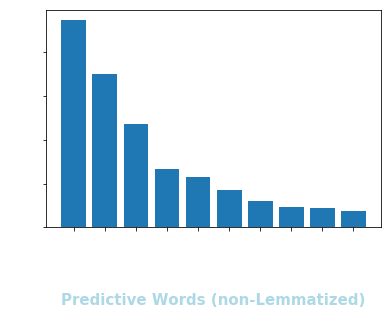

In [50]:
fig, ax = plt.subplots()  # blank plot 

x = np.arange(10) # I have 3 bars that I want to plot 
important_predictors = [0.09431894575830277, 0.06971186728958896, 0.04714937667855372, 
                       0.026770831058584767, 0.02301844857630113, 0.01698244629397894, 
                       0.012130591759925544, 0.0094263333626453, 0.008875519524833666, 
                       0.007321057804275869]  # these are the values (number of null cells per feature)
plt.bar(x, important_predictors)
plt.yticks( color = 'white', fontweight='bold', fontsize='13' )
plt.xticks(x, ('hiking', 'climbing', 'hike', 'trail', 'hikes', 'trails'
              , 'climb', 'climber', 'boots', 'climbers'), 
          rotation = 45, color = 'white', fontweight='bold', fontsize='13')   
plt.xlabel('Predictive Words (non-Lemmatized)', fontweight='bold', 
           color = 'lightblue', fontsize='15')
plt.show()

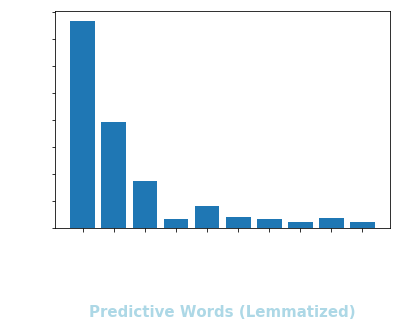

In [23]:
fig, ax = plt.subplots()  # blank plot 

x = np.arange(10) # I have 3 bars that I want to plot 
important_predictors = [(0.09431894575830277+0.04714937667855372+0.02301844857630113+0.00858623429979197+0.006748209510218811+0.00645990280520018+0.00525048217119907), 
                        (0.06971186728958896+0.012130591759925544+0.0094263333626453+0.007321057804275869),
                       (0.026770831058584767+0.01698244629397894), #trail
                        0.008875519524833666,# boots
                       (0.0124661351028495+0.007925392378485907), # bouldering 
                       0.010131486488687946, # gym
                       0.008892395785759314, # rope
                       0.006110683971042534, #park
                       (0.005977247986575609+0.0031363830587188904), #rock
                       0.005968526881709693 # sport
                       ] 
plt.bar(x, important_predictors)
plt.yticks( color = 'white', fontweight='bold', fontsize='13' )
plt.xticks(x, ('hike', 
              'climb', 
              'trail', 
              'boots', 
              'bouldering',
              'gym', 
              'rope', 
              'park', 
              'rock', 
              'sport'), 
          rotation = 45, color = 'white', fontweight='bold', fontsize='13')

plt.xlabel('Predictive Words (Lemmatized)', fontweight='bold', 
           color = 'lightblue', fontsize='15')
plt.show()

### For Loop that I didn't use but it works

In [ ]:
url = "https://www.reddit.com/r/hiking/new/.json"
headers = headers={'User-agent': 'BananaGram'}
request = requests.get(url, 
                     headers = headers)

reddit_dict1 = request.json()

param = {"after" : 't3_9biw3u' }

In [ ]:
posts = [ ]
after = None

for i in range(50):
    # print(i)
    if after == None: 
    #    params = { }
        url = "https://www.reddit.com/r/hiking.json"  # replace "hiking" with "climbing" for other subreddit
    else: 
        url = "https://www.reddit.com/r/hiking.json?after="+after
    request = requests.get(url, headers = headers)
    print(after)
    if request.status_code == 200:
        reddit_dict1 = request.json()
        posts.extend([c['data'] for c in reddit_dict1['data']['children']])
        after = reddit_dict1['data']['after']
    else:
        print(request.status_code)
        break
    time.sleep(2)